## Example Analysis of whales clicks
This notebook is an example for how the whale click dataset can be analyzed.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/numpy_pack.py','lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext,DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

%pylab inline

#!pip install pandas
#!pip install scipy

import pandas as pd
import datetime as dt

from scipy.io import loadmat,savemat,whosmat

from string import split
from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append('lib')
from row_parser import *

Parse_rules,field_names,RowObject = init_parser_parameters()

from pyspark.sql import DataFrame

CVS_Data=sc.textFile("/CVS/*/")


def parse(row):
    items=row.split(',')
    D=[]
    for pr in Parse_rules:
        start=pr['start']
        end=pr['end']
        parser=pr['parser']
        if end-start==1:
            D.append(parser(items[start]))
        else:
            D.append(parser(items[start:end]))
    return RowObject(*D)


RDD=CVS_Data.map(parse)

df=sqlContext.createDataFrame(RDD)

('time', 'datetime') {'start': 0, 'parser': <function parse_date at 0x7f51ee8d3f50>, 'end': 1, 'name': 'time'}
('species', 'str') {'start': 1, 'parser': <function parse_string at 0x7f51ee8651b8>, 'end': 2, 'name': 'species'}
('site', 'str') {'start': 2, 'parser': <function parse_string at 0x7f51ee8651b8>, 'end': 3, 'name': 'site'}
('rec_no', 'str') {'start': 3, 'parser': <function parse_string at 0x7f51ee8651b8>, 'end': 4, 'name': 'rec_no'}
('bout_i', 'int') {'start': 4, 'parser': <function parse_int at 0x7f51ee8650c8>, 'end': 5, 'name': 'bout_i'}
('peak2peak', 'float') {'start': 5, 'parser': <function parse_float at 0x7f51ee865140>, 'end': 6, 'name': 'peak2peak'}
('MSN', 'array', 202) {'start': 6, 'parser': <function parse_array at 0x7f51ee865050>, 'end': 208, 'name': 'MSN'}
('MSP', 'array', 101) {'start': 208, 'parser': <function parse_array at 0x7f51ee865050>, 'end': 309, 'name': 'MSP'}
('TPWS1', 'bool') {'start': 309, 'parser': <function parse_int at 0x7f51ee8650c8>, 'end': 310, 'n

In [4]:
t0=time()
print df.cache().count()
print time()-t0

t0=time()
print df.count()
time()-t0

6353182
81.8410570621
6353182


0.9717550277709961

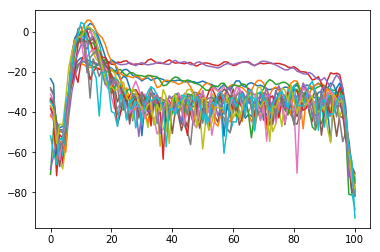

In [5]:
from row_parser import unpackArray
import numpy
def g(row):
    #return numpy.array([1,2]) #
    return unpackArray(row.MSP,data_type=numpy.float64)

def unpackArray(x,data_type=numpy.int16):
    return numpy.frombuffer(x,dtype=data_type)

In [12]:
eigval,eigvec=LA.eig(COV['Cov'])

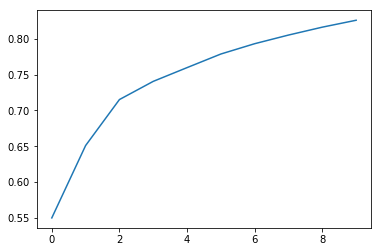

In [14]:
plot(cumsum(eigval[:10]))

In [18]:
Cuviers=df.filter(df.TPWS2==1).filter(df.species==u'Cuviers')

In [19]:
Gervais=df.filter(df.TPWS2==1).filter(df.species==u'Gervais')

In [51]:
V=eigvec[:,0:10] #vectors on which to project
def project(row):
    X=unpackArray(row.MSP,data_type=np.float64)
    return np.dot(X,V)

In [52]:
Cuvier_projections=Cuviers.rdd.map(project)
Gervais_projections=Gervais.rdd.map(project)

In [60]:
from pyspark.mllib.regression import LabeledPoint
Cuvier_samples = Cuvier_projections.map(lambda features:LabeledPoint(1, features))
Gervais_samples = Gervais_projections.map(lambda features:LabeledPoint(0, features))

In [61]:
Cuvier_samples.take(1)

[LabeledPoint(1.0, [-329.868023324,-38.1821474935,-37.5263766225,-21.9072256027,-81.6747052396,4.43508586256,42.5236069788,-34.0725297382,4.77455298326,-44.5184597908])]

In [62]:
Gervais_samples.take(1)

[LabeledPoint(0.0, [-229.723100758,-146.437852669,-16.1370242998,-2.60584692548,-63.518814625,-8.95553828363,40.8459241481,-56.4846709706,6.96983459632,-63.8284923538])]

In [63]:
samples = Cuvier_samples.union(Gervais_samples)
[training_data, test_data] = samples.randomSplit([0.8, 0.2])
training_data.cache()
test_data.cache()

PythonRDD[138] at RDD at PythonRDD.scala:48

In [64]:
def score(model):
    predictions = model.predict(test_data.map(lambda x: x.features))
    labels_and_preds = test_data.map(lambda x: x.label).zip(predictions)
    accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_data.count())
    return accuracy

In [65]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

algo = LogisticRegressionWithSGD()
model = algo.train(training_data)
score(model)

/usr/lib/spark/python/pyspark/mllib/classification.py:313: UserWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  "Deprecated in 2.0.0. Use ml.classification.LogisticRegression or "


0.8244371923225842

In [66]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

algo = LogisticRegressionWithLBFGS()
model = algo.train(training_data)
score(model)

0.8272713717813365

In [70]:
from pyspark.mllib.classification import SVMWithSGD

algo = SVMWithSGD()
model = algo.train(training_data)
score(model)

0.8242520147083934

In [71]:
from pyspark.mllib.tree import DecisionTree

algo = DecisionTree()
model = algo.trainClassifier(training_data,numClasses=2,categoricalFeaturesInfo={})
score(model)

0.8326619642775548

In [73]:
from pyspark.mllib.tree import RandomForest

algo = RandomForest()
model = algo.trainClassifier(training_data,numClasses=2,categoricalFeaturesInfo={},numTrees=16)
score(model)

0.8165935976643571

In [ ]:
from pyspark.mllib.tree import GradientBoostedTrees

algo = GradientBoostedTrees()
model = algo.trainClassifier(training_data,categoricalFeaturesInfo={})
score(model)